In [1]:
import scipy
import numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

In [2]:
df = pd.read_csv("Final_Thesis_Dataset.csv", index_col = 0)
df['Day'] = df['Day'].astype('category')
df['DemandTime'] = df['DemandTime'].astype('category')

Split into training and test data

In [3]:
train_size = int(len(df)*0.75)
train_dataset, test_dataset = df.iloc[:train_size], df.iloc[train_size:]

Plot training and test data

Dimension of train data:  (4077, 39)
Dimension of test data:  (1360, 39)


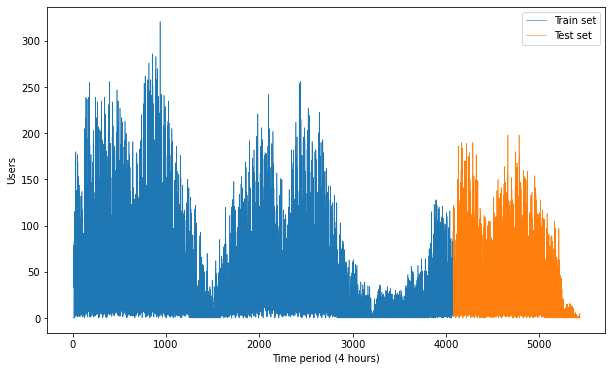

In [4]:
# Plot train and test data
plt.figure(figsize = (10, 6))
#plt.figure(figsize = (15, 6))

#Line width
lw = 0.6

sns.lineplot(x = train_dataset.index, y = train_dataset.Users, linewidth = lw)
sns.lineplot(x = test_dataset.index, y = test_dataset.Users, linewidth = lw)
plt.xlabel('Time (hour)')
plt.ylabel('Users')
plt.legend(['Train set', 'Test set'], loc='upper right')
plt.xlabel('Time period (4 hours)')

print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

In [6]:
# Split train data to X and y
X_train = train_dataset.drop(['Users'], axis = 1)
y_train = train_dataset.loc[:,['Users']]

# Split test data to X and y
X_test = test_dataset.drop(['Users'], axis = 1)
y_test = test_dataset.loc[:,['Users']]

In [7]:
# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [8]:
# Create a 3D input
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 1
X_test, y_test = create_dataset(test_x_norm, test_y_norm,   
                                TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, 
                                  TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_train.shape)

X_train.shape:  (1359, 1, 38)
y_train.shape:  (4076, 1)
X_test.shape:  (1359, 1, 38)
y_test.shape:  (4076, 1)


In [9]:
# Function for LSTM and GRU model
def create_model(units, m, learning_rate):
    model = Sequential()
    model.add(m (units = units, return_sequences = True,
                input_shape = [X_train.shape[1], X_train.shape[2]], 
               activation='relu'))
    model.add(Dropout(0.2))
    
    initializer = tf.keras.initializers.GlorotUniform()
    model.add(m (units = units, kernel_initializer=initializer, 
               activation='relu'))

    model.add(Dropout(0.2))
    model.add(Dense(units = 1, activation = "relu"))
    
    opt = keras.optimizers.Adam(learning_rate= learning_rate)
    #Compile model
    model.compile(loss='mae', optimizer= opt)
    return model

# GRU and LSTM
model_gru = create_model(16, GRU, 0.001)
model_lstm = create_model(16, LSTM, 0.001)

In [10]:
# Fitting LSTM and GRU
def fit_model(model):
    earlystopping  = keras.callbacks.EarlyStopping(monitor = 'val_loss',
   
    #The patience for early stopping is set to 20 as the validation and training loss could zig zag.
                                               patience = 20)
    #Epochs at 200 is simply a maximum in case the model keeps running with continued improvement.
    #Early stopping is meant to prevent overfitting.
    history = model.fit(X_train, y_train, epochs = 200,  
                        validation_split = 0.2, 
                        callbacks = [earlystopping])
    return history
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)

Epoch 1/200
102/102 [==============================] - 0s 4ms/step - loss: 0.1505 - val_loss: 0.0602
Epoch 2/200
102/102 [==============================] - 0s 1ms/step - loss: 0.0982 - val_loss: 0.0573
Epoch 3/200
102/102 [==============================] - 0s 1ms/step - loss: 0.0841 - val_loss: 0.0521
Epoch 4/200
102/102 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0485
Epoch 5/200
102/102 [==============================] - 0s 1ms/step - loss: 0.0742 - val_loss: 0.0470
Epoch 6/200
102/102 [==============================] - 0s 1ms/step - loss: 0.0718 - val_loss: 0.0470
Epoch 7/200
102/102 [==============================] - 0s 1ms/step - loss: 0.0702 - val_loss: 0.0480
Epoch 8/200
102/102 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0512
Epoch 9/200
102/102 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0515
Epoch 10/200
102/102 [==============================] - 0s 1ms/step - loss: 0.0647 - val_lo

102/102 [==============================] - 0s 1ms/step - loss: 0.0568 - val_loss: 0.0426
Epoch 24/200
102/102 [==============================] - 0s 1ms/step - loss: 0.0584 - val_loss: 0.0397
Epoch 25/200
102/102 [==============================] - 0s 1ms/step - loss: 0.0576 - val_loss: 0.0375
Epoch 26/200
102/102 [==============================] - 0s 1ms/step - loss: 0.0566 - val_loss: 0.0383
Epoch 27/200
102/102 [==============================] - 0s 1ms/step - loss: 0.0575 - val_loss: 0.0398
Epoch 28/200
102/102 [==============================] - 0s 2ms/step - loss: 0.0573 - val_loss: 0.0388
Epoch 29/200
102/102 [==============================] - 0s 1ms/step - loss: 0.0573 - val_loss: 0.0384
Epoch 30/200
102/102 [==============================] - 0s 1ms/step - loss: 0.0574 - val_loss: 0.0401
Epoch 31/200
102/102 [==============================] - 0s 1ms/step - loss: 0.0558 - val_loss: 0.0379
Epoch 32/200
102/102 [==============================] - 0s 1ms/step - loss: 0.0561 - val_loss: 

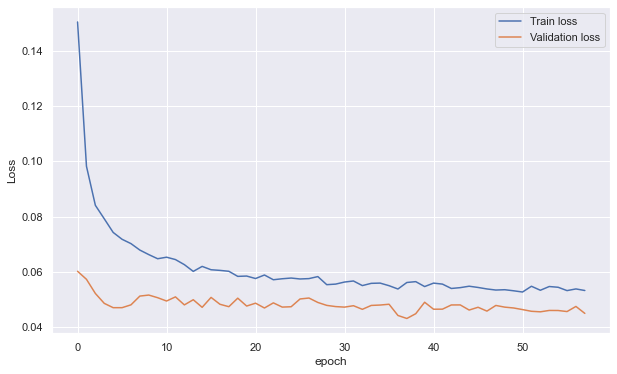

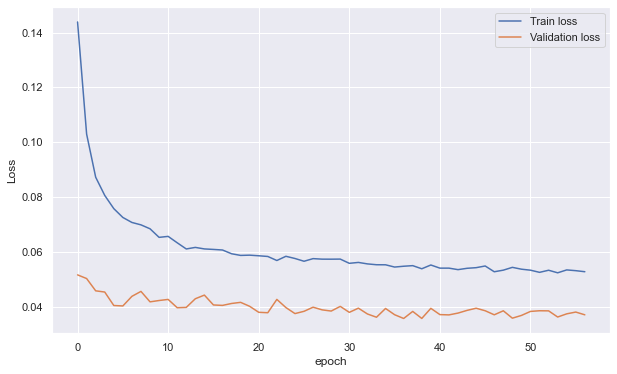

In [11]:
# Plot train loss and validation loss
def plot_loss (history):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plot_loss (history_lstm)
#plt.savefig("LSTM_Loss.png")
plot_loss (history_gru)
#plt.savefig("GRU_Loss.png")

In [12]:
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

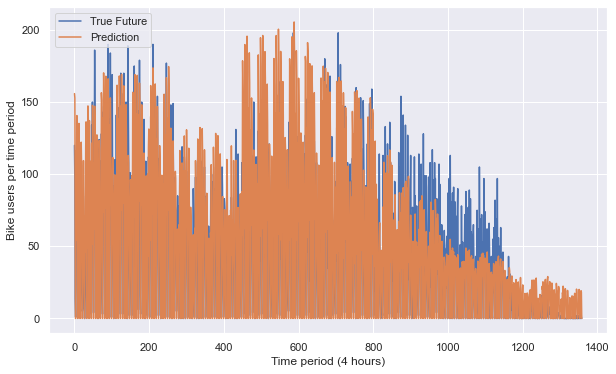

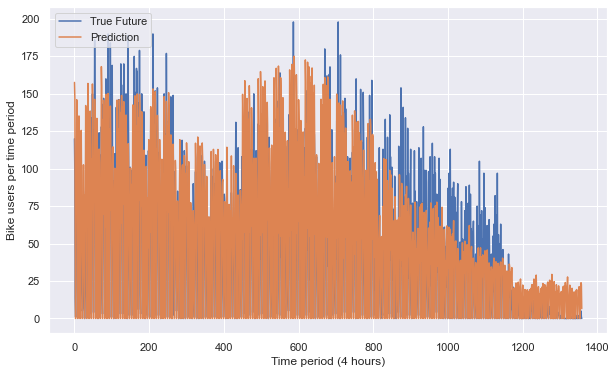

In [13]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)
# Plot true future vs prediction
def plot_future(prediction, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
        
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='True Future')
    
    plt.plot(np.arange(range_future),np.array(prediction),
            label='Prediction')
    
    plt.legend(loc='upper left')
    plt.xlabel('Time period (4 hours)')
    plt.ylabel('Bike users per time period')

plot_future(prediction_lstm, y_test)
#plt.savefig("LSTM_Results.png")
plot_future(prediction_gru, y_test)
#plt.savefig("GRU_Results.png")

In [14]:
from prettytable import PrettyTable

def array_with_prediction(predictions, actual):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    rsquared = r2_score(actual, predictions)
    array = np.array([mae, rmse, rsquared])
    return array
###########################################################################
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('R-squared: {:.4f}'.format(r2_score(actual, predictions)))
    print('')

evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')
################################################################################
lstm = array_with_prediction(prediction_lstm, y_test)
gru = array_with_prediction(prediction_gru, y_test)

LSTM:
Mean Absolute Error: 16.0292
Root Mean Square Error: 23.8225
R-squared: 0.7393

GRU:
Mean Absolute Error: 14.9307
Root Mean Square Error: 21.2435
R-squared: 0.7927



In [15]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('R-squared: {:.4f}'.format(r2_score(actual, predictions)))
    print('')

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


train_size = int(len(df)*0.75)
train_dataset, test_dataset = df.iloc[:train_size], df.iloc[train_size:]


# Split train data to X and y
X_train = train_dataset.drop(['Users'], axis = 1)
y_train = np.ravel(train_dataset.loc[:,['Users']])

# Split test data to X and y
X_test = test_dataset.drop(['Users'], axis = 1)
y_test = np.ravel(test_dataset.loc[:,['Users']])

clf = RandomForestRegressor(n_estimators=1000)

clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

evaluate_prediction(y_pred, y_test, 'RF')

RF:
Mean Absolute Error: 17.0710
Root Mean Square Error: 24.4900
R-squared: 0.7243



In [17]:
models = ["Metrics", "LSTM", "GRU", "RF"]
metrics = np.array(["MAE", "RMSE", "R-Squared"])

lstm = ["%.2f" % member for member in lstm]
gru = ["%.2f" % member for member in gru]
rf = array_with_prediction(y_pred, y_test)
rf = ["%.2f" % member for member in rf]

table = PrettyTable()

table.add_column(models[0], metrics)
table.add_column(models[1], lstm)
table.add_column(models[2], gru)
table.add_column(models[3], rf)


table

Metrics,LSTM,GRU,RF
MAE,16.03,14.93,17.07
RMSE,23.82,21.24,24.49
R-Squared,0.74,0.79,0.72


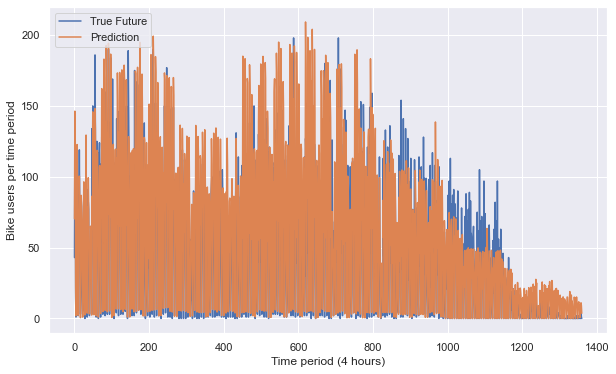

In [18]:
plot_future(y_pred, y_test)
#plt.savefig("RF_Results.png")

In [19]:
#Too large to put in the thesis
#from sklearn.datasets import load_boston
#from sklearn.ensemble import RandomForestRegressor
#from sklearn import tree
#from dtreeviz.trees import dtreeviz # will be used for tree visualization
#from matplotlib import pyplot as plt

#plt.figure(figsize=(20,20))
#_ = tree.plot_tree(clf.estimators_[0], feature_names=X_test.columns, filled=True)

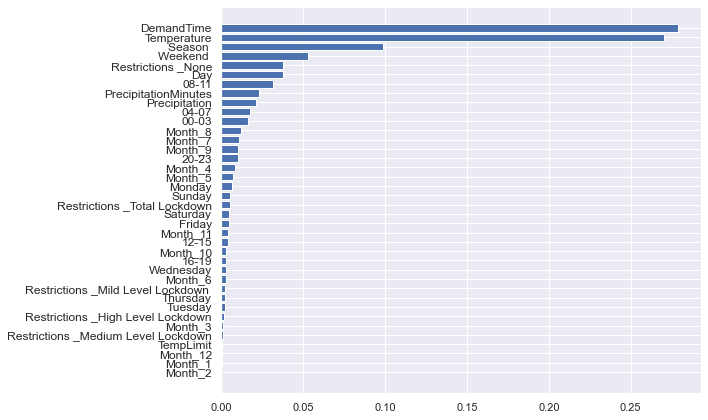

In [20]:
#Feature importance
sortclf = clf.feature_importances_.argsort()

plt.barh(X_test.columns[sortclf],clf.feature_importances_[sortclf])

plt.yticks(fontsize=12)
plt.tight_layout()

#plt.savefig("featureimportance.png")
plt.show()